# load the data and prep it for modelling

The basic idea in this notebook is to get a sense for how various models perform.  The assessment is based simply on the train and test accuracy.

In another notebook the models will be evaluated with cross validation and compared with grid searching.

In [21]:
# the usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# my utilities
from crash_utils.zip_code_and_borough_from_coords import zip_code_and_borough_from_coords
from crash_utils.fix_vehicle_names import fix_vehicle_names
from crash_utils.make_crash_features import make_crash_features
from crash_utils.basic_cleaning import basic_cleaning
from crash_utils.prepare_data_for_modelling import prepare_data_for_modelling

In [22]:
data_path = "/Users/Mark/brainstation/capstone/nyc_bike_crash_analysis/data/"
df = pd.read_csv(data_path + "Motor_Vehicle_Collisions_-_Crashes.csv")

In [23]:
# fill in missing zip coded and boroughs using lat/lon
df = zip_code_and_borough_from_coords(df)

In [26]:
#df["ZIP CODE"].unique().shape

In [4]:
# perform some basic data munging operations (see `crash_utils/basic_cleaning.py` for details)
df = basic_cleaning(df)

In [5]:
## clean up the VEHICLE TYPE CODE columns
df = fix_vehicle_names(df)

In [6]:
df.shape

(47468, 20)

In [7]:
# prepare the data for modelling
# drop columns
# set up target
# run "make_crash_features.py"
# OHE the text columns
# count-vectorize the vehicles and crash factors

df = prepare_data_for_modelling(df)

In [8]:
df.shape

(47318, 335)

# now test some models!

In [9]:
# machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## extract the features and targets from the big dataframe

In [10]:
# extract target and features and then train-test-split
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
print(y_train.value_counts().sort_index())
n_min = np.sum(y_train == 0)
n_maj = np.sum(y_train == 1)

0.0     8177
1.0    27311
Name: outcome, dtype: int64


In [12]:
# fix the class imbalance with upsampling
from sklearn.utils import resample

minority_mask = y_train == 0

X_upsampled, y_upsampled = resample(X_train.loc[minority_mask], 
                                    y_train.loc[minority_mask], 
                                    replace = True, 
                                    n_samples = n_maj)

X_train_bal = np.vstack((X_train[y_train == 1], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 1], y_upsampled))

In [13]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))
print(np.sum(y_train_bal==0))
print(np.sum(y_train_bal==1))

8177
27311
27311
27311


In [14]:
# also scale the data for those algorithms which would benefit (e.g., KNN)
scaler = StandardScaler().fit(X_train_bal)

X_train_scaled = scaler.transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

## Logistic classifier

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train_bal)

print("training set accuracy",round(lr.score(X_train_scaled, y_train_bal),3))
print("test set accuracy",round(lr.score(X_test_scaled, y_test),3))

training set accuracy 0.625
test set accuracy 0.647


In [31]:
Cs = 10**np.arange(-6.,7.,1.)
test_score = []
train_score = []

for C in Cs:
    lr = LogisticRegression(C = C).fit(X_train_scaled, y_train_bal)
    train_score.append(lr.score(X_train_scaled, y_train_bal))
    test_score.append(lr.score(X_test_scaled, y_test))
    print(C,end="\r")

In [32]:
max_ind = np.argmax(test_score)
print("max test score of", round(test_score[max_ind],3))
print("max test score at C = ",Cs[max_ind])

max test score of 0.647
max test score at C =  0.01


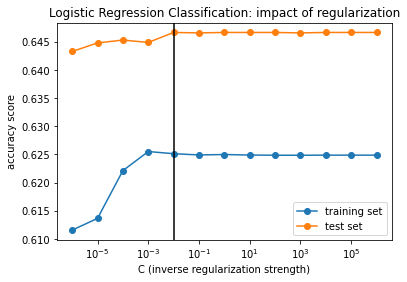

In [33]:
# Visualize the result
plt.figure()
plt.plot(Cs, train_score, label='training set', marker='o')
plt.plot(Cs, test_score, label='test set', marker='o')
plt.xscale("log")
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('accuracy score')
plt.title("Logistic Regression Classification: impact of regularization")
plt.axvline(Cs[max_ind],color="k")
plt.legend()
plt.show()

In [48]:
# break out the coefficient values and feature names for text columns
coeffs = lr.coef_.reshape(-1)[253:]
features = X.columns[253:]
print(features.shape)
print(coeffs.shape)

(81,)
(81,)


In [49]:
word_df = pd.DataFrame({"coeffs":coeffs, "word":features})
word_df.sort_values(by="coeffs",ascending=False,inplace=True)

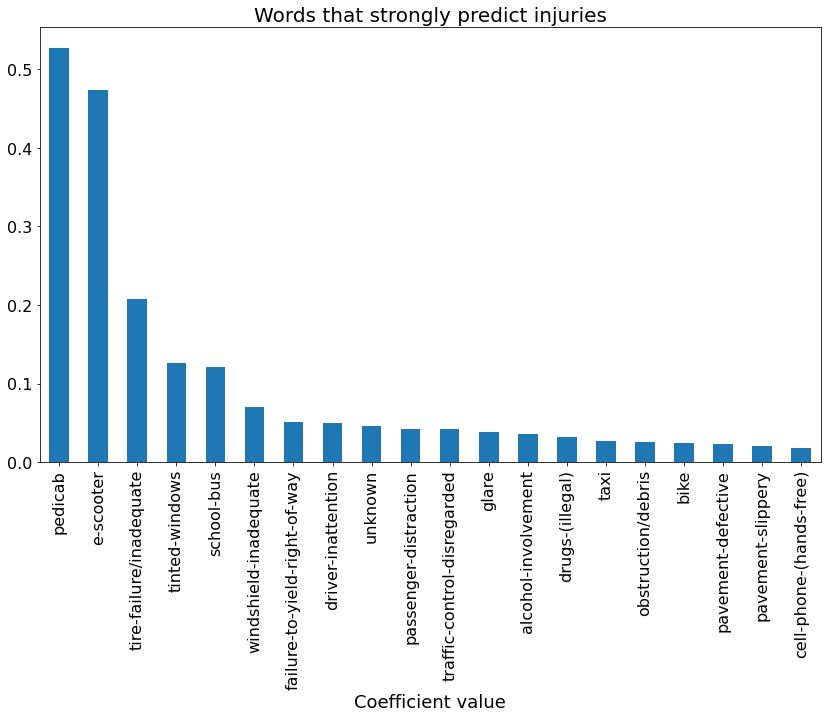

In [55]:
word_df.head(20).plot.bar(x = "word", rot=90, figsize=(14,8), fontsize=16, legend=None);
plt.xlabel("Coefficient value",size=18);
plt.ylabel("");
plt.title("Words that strongly predict injuries",size = 20);

## Decision Tree Classifier

In [15]:
# instantiate and fit DTC

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_bal, y_train_bal)


# score model on train and test sets
print(round(dtc.score(X_train_bal, y_train_bal),3))
print(round(dtc.score(X_test, y_test),3))

0.999
0.676


__little mini hyperparameter search__

In [ ]:
#depths = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
depths = np.arange(1,211,10)
test_score = []
train_score = []

for depth in depths:
    dtc = DecisionTreeClassifier(max_depth = depth)
    dtc.fit(X_train_bal,y_train_bal)
    train_score.append(dtc.score(X_train_bal, y_train_bal))
    test_score.append(dtc.score(X_test, y_test))
    print(depth,end="\r")

In [ ]:
max_ind = np.argmax(test_score)
print("max test score of", round(test_score[max_ind],3))
print("max test score at max_depth of",depths[max_ind])

In [ ]:
# Visualize the result
plt.figure()
plt.plot(depths, train_score, label='training set', marker='o')
plt.plot(depths, test_score, label='test set', marker='o')
#plt.xscale("log")
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.title("DTC: impact of max depth")
plt.axvline(depths[max_ind],color="k")
plt.legend()
plt.show()

In [ ]:
# predict test and train
y_pred_test = dtc.predict(X_test)
y_pred_train= dtc.predict(X_train_bal)

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_df = pd.DataFrame(data = conf_matrix,
                       index = ['True Class 0','True Class 1'],
                       columns = ['Predicted Class 0','Predicted Class 1'])

conf_df

In [16]:
counts_df = pd.DataFrame(y_test.value_counts().sort_index())
counts_df.rename(columns = {"outcome":"number"}, inplace=True)
counts_df["outcome"] = ["no injury","injury"]
counts_df.index.name = "encoding"
counts_df

,number,outcome
encoding,,
0.0,2719,no injury
1.0,9111,injury


In [17]:
ConfusionMatrixDisplay(conf_matrix).plot()

NameError: name 'conf_matrix' is not defined

In [18]:
#min_leafs = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
min_leafs = np.arange(1,211,10)
test_score = []
train_score = []

for leaf in min_leafs:
    dtc = DecisionTreeClassifier(max_depth = 60, min_samples_leaf = leaf)
    dtc.fit(X_train_bal,y_train_bal)
    test_score.append(dtc.score(X_test, y_test))
    train_score.append(dtc.score(X_train_bal, y_train_bal))
    print(leaf,end="\r")

In [ ]:
max_ind = np.argmax(test_score)
print("max test score of", round(test_score[max_ind],3))
print("max test score at min_samples_leaf of",min_leafs[max_ind])

In [ ]:
# Visualize the result
plt.figure()
plt.plot(min_leafs, train_score, label='training set', marker='o')
plt.plot(min_leafs, test_score, label='test set', marker='o')
#plt.xscale("log")
plt.xlabel('min samples per leaf')
plt.ylabel('accuracy score')
plt.title("DTC: impact of min. samples per leaf")
plt.legend()
plt.show()

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# optimized RF classifier
rf = RandomForestClassifier(max_depth = 50, n_estimators = 100, n_jobs = -1)
rf.fit(X_train_bal, y_train_bal)


# score model on train and test sets
print(round(rf.score(X_train_bal, y_train_bal),3))
print(round(rf.score(X_test, y_test),3))

In [ ]:
#depths = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
depths = np.arange(1,211,30)
test_score = []
train_score = []

for depth in depths:
    rf = RandomForestClassifier(max_depth = depth, n_estimators = 80, n_jobs = -1)
    rf.fit(X_train_bal,y_train_bal)
    train_score.append(rf.score(X_train_bal, y_train_bal))
    test_score.append(rf.score(X_test, y_test))
    print(depth,end="\r")

In [ ]:
max_ind = np.argmax(test_score)
print("max test score of", round(test_score[max_ind],3))
print("max test score at max_depth of",depths[max_ind])

In [ ]:
# Visualize the result
plt.figure()
plt.plot(depths, train_score, label='training set', marker='o')
plt.plot(depths, test_score, label='test set', marker='o')
#plt.xscale("log")
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.title("Random Forest: impact of max depth")
plt.axvline(depths[max_ind],color="k")
plt.legend()
plt.show()

In [ ]:
estimators = np.arange(10,200,10)
test_score = []
train_score = []

for estimator in estimators:
    rf = RandomForestClassifier(n_estimators = estimator, n_jobs=-1)
    rf.fit(X_train,y_train)
    test_score.append(rf.score(X_test, y_test))
    train_score.append(rf.score(X_train_bal, y_train_bal))
    print(estimator,end="\r")

In [ ]:
max_ind = np.argmax(test_score)
print("max test score of", round(test_score[max_ind],3))
print("max test score at n_estimators of",estimators[max_ind])

In [ ]:
# Visualize the result
plt.figure()
plt.plot(estimators, train_score, label='training set', marker='o')
plt.plot(estimators, test_score, label='test set', marker='o')
plt.xlabel("number of estimators")
plt.ylabel('accuracy score')
plt.title("Random forest: impact of number of estimators")
plt.legend()
plt.show()

In [ ]:
estimators = np.arange(10,200,10)
test_score = []
train_score = []

for estimator in estimators:
    rf = RandomForestClassifier(n_estimators = estimator, n_jobs=-1)
    rf.fit(X_train,y_train)
    test_score.append(rf.score(X_test, y_test))
    train_score.append(rf.score(X_train_bal, y_train_bal))
    print(estimator,end="\r")

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_bal)

# score model on train and test sets
print(round(gnb.score(X_train_scaled, y_train_bal),3))
print(round(gnb.score(X_test_scaled, y_test),3))

In [ ]:
# predict test and train
y_pred_test = gnb.predict(X_test_scaled)
y_pred_train= gnb.predict(X_train_scaled)

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_df = pd.DataFrame(data = conf_matrix,
                       index = ['True Class 0','True Class 1'],
                       columns = ['Predicted Class 0','Predicted Class 1'])

conf_df

## boosting

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train_bal)


# score model on train and test sets
print(round(gb.score(X_train_scaled, y_train_bal),3))
print(round(gb.score(X_test_scaled, y_test),3))

In [ ]:
estimators = np.arange(10,200,20)
test_score = []
train_score = []

for estimator in estimators:
    gb = GradientBoostingClassifier(n_estimators = estimator)
    gb.fit(X_train,y_train)
    test_score.append(gb.score(X_test, y_test))
    train_score.append(gb.score(X_train, y_train))
    print(estimator,end="\r")

In [ ]:
# Visualize the result
plt.figure()
plt.plot(estimators, train_score, label='training set', marker='o')
plt.plot(estimators, test_score, label='test set', marker='o')
plt.xlabel("number of estimators")
plt.ylabel('accuracy score')
plt.title("Random forest: impact of number of estimators")
plt.legend()
plt.show()

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#fitting Adaptive Boosting
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train_bal)

# score model on train and test sets
print(round(ada.score(X_train_scaled, y_train_bal),3))
print(round(ada.score(X_test_scaled, y_test),3))

## K-Nearest Neighbors

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_jobs = -1)
# knn.fit(X_train_scaled, y_train_bal)

# # score model on train and test sets
# print(round(knn.score(X_train_scaled, y_train_bal),3))
# print(round(knn.score(X_test_scaled, y_test),3))

## MLP classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(20,100,500,100,20), solver='lbfgs')

nn.fit(X_train_scaled,y_train)

print(round(nn.score(X_train_scaled, y_train),3))
print(round(nn.score(X_test_scaled, y_test),3))


#nn.fit(X_train_scaled,y_train)

# score model on train and test sets
# print(round(nn.score(X_train_scaled, y_train),3))
# print(round(nn.score(X_test_scaled, y_test),3))

In [ ]:
# predict test and train
y_pred_test = nn.predict(X_test_scaled)
y_pred_train= nn.predict(X_train_scaled)

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_df = pd.DataFrame(data = conf_matrix,
                       index = ['True Class 0','True Class 1','True Class 2'],
                       columns = ['Predicted Class 0','Predicted Class 1','Predicted Class 2'])

conf_df

## Tensorflow/Keras Feedforward NN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
#model.add(layers.Dense(500, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(20, activation="relu"))

# Declare the output layer
model.add(layers.Dense(3, activation="softmax"))

In [ ]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [ ]:
# extract target and features and then train-test-split
X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train, y_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

type(X_train_scaled)

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=50, verbose=1)

In [ ]:
# Evaluate the network
train_accuracy = history.history["binary_accuracy"][-1]

result = model.evaluate(X_test,y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}") 